# Notebook 01 — Problemverständnis, Datenbeschreibung & EDA (Anforderungen 1–3)

**Projekt:** Vorhersage der Fahrtdauer von Fahrradaktivitäten (Regression)  
**Zielvariable:** `moving_time` (Sekunden)

Dieses Notebook deckt die Anforderungen **1–3** ab:
1. **Problembeschreibung**
2. **Datenquelle & Datenbeschreibung**
3. **Explorative Datenanalyse (EDA)**

## Einordnung im Repository
- **Notebook 08** ist der **Final Report** (Abgabe-/Präsentations-Notebook) und lädt seine Ergebnisse aus Artefakten.
- Notebook 01 dient dem **Verständnis der Rohdaten** und erzeugt `processed.csv` als Grundlage.

## Datenquelle
- Kaggle: “Outdoor cycling metrics” (dorinaferencsik).  
  Hinweis: Der Datensatz wird im Repository nicht mitversioniert. Die Lizenz-/Nutzungsangaben sind auf der Kaggle-Datensatzseite dokumentiert.

## Wichtige Regel (Leakage)
- `elapsed_time` ist in den Daten vorhanden, wird später **nicht als Feature** genutzt (**Leakage-Risiko**).

## Outputs dieses Notebooks
- `data/processed/processed.csv`
- `data_derived/01_cleaning_report.csv`
- `data_derived/01_raw_schema_and_missing.csv`
- `data_derived/01_raw_corr_with_target.csv`
- `plots/01_...` (Abbildungen, 300 dpi)

In [7]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())

PATH_RAW = REPO_ROOT / "data" / "raw" / "raw.csv"                 # lokal
PATH_PROCESSED = REPO_ROOT / "data" / "processed" / "processed.csv"
PATH_DERIVED = REPO_ROOT / "data_derived"
PATH_PLOTS = REPO_ROOT / "plots"

PATH_PROCESSED.parent.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

TARGET = "moving_time"
LEAKAGE_COLS = ["elapsed_time"]

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(
            "[ERROR] Datei nicht gefunden.\n"
            f"Erwarteter Pfad: {path}\n"
            "Lege die Rohdaten als data/raw/raw.csv ab (siehe README / Kaggle-Quelle)."
        )
    return pd.read_csv(path)

def savefig(path: Path, dpi: int = 300) -> Path:
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    return path

print("REPO_ROOT:", REPO_ROOT)
print("PATH_RAW:", PATH_RAW)
print("PATH_PROCESSED:", PATH_PROCESSED)
print("PATH_DERIVED:", PATH_DERIVED)
print("PATH_PLOTS:", PATH_PLOTS)

REPO_ROOT: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer
PATH_RAW: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/raw/raw.csv
PATH_PROCESSED: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/processed.csv
PATH_DERIVED: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived
PATH_PLOTS: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots


In [8]:
df_raw = safe_read_csv(PATH_RAW)
print("Raw shape:", df_raw.shape)

print("Target vorhanden (moving_time):", TARGET in df_raw.columns)
print("Leakage-Spalte vorhanden (elapsed_time):", "elapsed_time" in df_raw.columns)

# Schema + Missing
schema = pd.DataFrame({
    "column": df_raw.columns,
    "dtype": [str(t) for t in df_raw.dtypes],
    "missing_count": df_raw.isna().sum().values,
})
schema["missing_pct"] = schema["missing_count"] / len(df_raw)
schema = schema.sort_values(["missing_pct", "missing_count"], ascending=False).reset_index(drop=True)

display(schema)

schema_path = PATH_DERIVED / "01_raw_schema_and_missing.csv"
schema.to_csv(schema_path, index=False)
print("Saved:", schema_path)

# Korrelationen mit Target (nur numerische Spalten)
num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]  # Target später separat

if TARGET in df_raw.columns and len(num_cols) > 0:
    corr = df_raw[[TARGET] + num_cols].corr(numeric_only=True)[TARGET].drop(TARGET)
    corr_df = corr.sort_values(key=lambda s: s.abs(), ascending=False).reset_index()
    corr_df.columns = ["feature", "corr_with_moving_time"]
    display(corr_df)

    corr_path = PATH_DERIVED / "01_raw_corr_with_target.csv"
    corr_df.to_csv(corr_path, index=False)
    print("Saved:", corr_path)
else:
    print("[WARN] Korrelationen nicht berechnet (Target fehlt oder keine numerischen Features).")

Raw shape: (10158, 14)
Target vorhanden (moving_time): True
Leakage-Spalte vorhanden (elapsed_time): True


,column,dtype,missing_count,missing_pct
0,end_coordinates,object,8195,0.806753
1,start_coordinates,object,8179,0.805178
2,lowest_elevation,float64,172,0.016932
3,highest_elevation,float64,171,0.016834
4,hashed_id,object,0,0.000000
5,age_group,int64,0,0.000000
6,gender,object,0,0.000000
7,average_speed,float64,0,0.000000
8,distance,float64,0,0.000000
9,elapsed_time,int64,0,0.000000


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/01_raw_schema_and_missing.csv


,feature,corr_with_moving_time
0,distance,0.951408
1,total_elevation_gain,0.790216
2,max_speed,0.485221
3,highest_elevation,0.393653
4,elapsed_time,0.318615
5,lowest_elevation,-0.037897
6,average_speed,-0.025275
7,age_group,0.020316


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/01_raw_corr_with_target.csv


## Datenbereinigung und Erstellung von `processed.csv`

Ziel: eine bereinigte Datengrundlage mit den für die Modellierung relevanten Kernspalten.

Bereinigungsschritte:
1. Auswahl der Kernspalten
2. Entfernen von Zeilen mit fehlenden Werten in den Kernspalten
3. Plausibilitätsfilter (z. B. positive Distanz und positive Fahrtdauer)

Ergebnis:
- `data/processed/processed.csv`
- `data_derived/01_cleaning_report.csv` (Protokoll der Zeilenreduktion)

In [9]:
# 1) Kernspalten (minimaler Modell-/EDA-Scope)
core_cols = [
    "distance",
    "total_elevation_gain",
    "highest_elevation",
    "lowest_elevation",
    "elapsed_time",   # nur zur QC/EDA; später nicht als Feature
    "moving_time",
]

missing_core = [c for c in core_cols if c not in df_raw.columns]
if missing_core:
    raise ValueError(f"[ERROR] Kernspalten fehlen in raw.csv: {missing_core}")

report_rows = []

df = df_raw[core_cols].copy()
report_rows.append({"step": "raw_selected_cols", "rows": len(df), "removed": np.nan})

# 2) dropna in Kernspalten
before = len(df)
df = df.dropna(subset=["distance", "total_elevation_gain", "highest_elevation", "lowest_elevation", "moving_time"])
report_rows.append({"step": "dropna_core_cols", "rows": len(df), "removed": before - len(df)})

# 3) Plausibilitätsfilter (konservativ)
before = len(df)
df = df[
    (df["distance"] > 0) &
    (df["moving_time"] > 0) &
    (df["total_elevation_gain"] >= 0)
].copy()
report_rows.append({"step": "plausibility_filters", "rows": len(df), "removed": before - len(df)})

cleaning_report = pd.DataFrame(report_rows)
display(cleaning_report)

# Exporte
report_path = PATH_DERIVED / "01_cleaning_report.csv"
cleaning_report.to_csv(report_path, index=False)
print("Saved:", report_path)

df.to_csv(PATH_PROCESSED, index=False)
print("Saved:", PATH_PROCESSED)

print("processed shape:", df.shape)

,step,rows,removed
0,raw_selected_cols,10158,NaN
1,dropna_core_cols,9986,172.0
2,plausibility_filters,9948,38.0


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/01_cleaning_report.csv
Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/processed.csv
processed shape: (9948, 6)


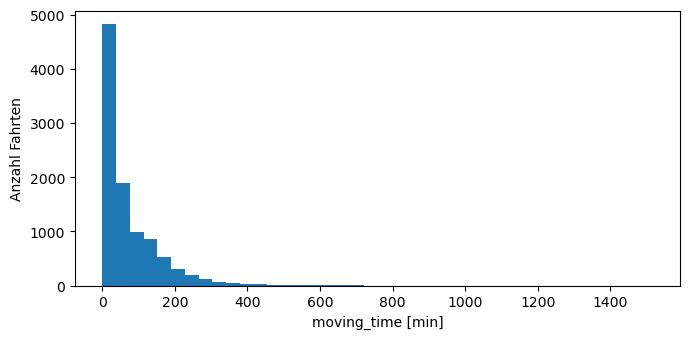

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/01_target_distribution_moving_time_min.png


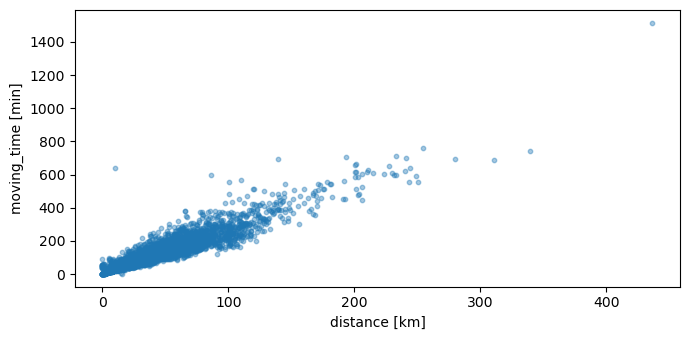

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/01_scatter_distance_km_vs_moving_time_min.png


In [10]:
# EDA Plots auf processed

dfp = pd.read_csv(PATH_PROCESSED)

# moving_time in Minuten für Visualisierung
moving_time_min = dfp["moving_time"] / 60.0

plt.figure(figsize=(7, 3.5))
plt.hist(moving_time_min, bins=40)
plt.xlabel("moving_time [min]")
plt.ylabel("Anzahl Fahrten")
p1 = savefig(PATH_PLOTS / "01_target_distribution_moving_time_min.png", dpi=300)
plt.show()
print("Saved:", p1)

# distance in km für Visualisierung
distance_km = dfp["distance"] / 1000.0 if dfp["distance"].max() > 500 else dfp["distance"]

plt.figure(figsize=(7, 3.5))
plt.scatter(distance_km, moving_time_min, s=10, alpha=0.4)
plt.xlabel("distance [km]")
plt.ylabel("moving_time [min]")
p2 = savefig(PATH_PLOTS / "01_scatter_distance_km_vs_moving_time_min.png", dpi=300)
plt.show()
print("Saved:", p2)